In [1]:
import os, sys
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Merge, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import SGD, Adam, Adamax
from keras.models import model_from_yaml
from keras.regularizers import l1, l2
from load_dataset import get_data, dataset
from utils import print_metadata, get_dgaze_frames_count, split_data, plot_gaze_points, save_model, load_model

from sklearn import preprocessing
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
import copy
import cv2 

from numpy.random import seed
seed(33)

from tensorflow import set_random_seed
set_random_seed(26)

import random 
random.seed(10)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# from keras import backend as k
# import tensorflow as tf
# config = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1,
# allow_soft_placement=True, device_count = {'CPU': 1})
# sess = tf.Session(graph=tf.get_default_graph(),config=config)
# k.set_session(sess)

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
data_path = '/ssd_scratch/cvit/isha/eye_gaze_mapping/DGM_final2/dataset_samples_callibrated/'
model_save = '/ssd_scratch/cvit/isha/DGAZE2/DGAZE_weights/weights_proposed_approach_normalized'
drivers = os.listdir(data_path)
ndrivers = len(drivers)
sequences = 112

# Driver_data is dict contatining drivers user1, user 2.....etc. For each driver, we have 112 sequences and for   
# each sequence we have features like ['face_location', 'headpose_pupil', 'left_eye', 'gaze_point', 'right_eye'] 
driver_data = get_data(data_path, drivers, sequences)

# Print the total numer of frames in the dataset
get_dgaze_frames_count(driver_data, drivers)

# Prints the DGAZE Metadata including list of drivers, sequences and features 
#print_metadata(driver_data, ['drivers', 'sequences', 'features'])
print_metadata(driver_data, ['features'])

100%|██████████| 20/20 [00:06<00:00,  3.09it/s]


Total frames in DGAZE dataset is 227178
List of Features: ['right_eye', 'gaze_point', 'left_eye', 'headpose_pupil', 'face_location']



In [3]:
seq_range = np.arange(10, sequences+1)
nsequences = len(seq_range)
ndrivers = len(drivers)
random.shuffle(drivers)

dsplit = [int(0.8*ndrivers),int(0.1*ndrivers), int(0.1*ndrivers)]
gp_split = [int(0.6*nsequences),int(0.2*nsequences), int(0.2*nsequences)]
data_split = split_data(drivers, seq_range, dsplit, gp_split)

In [ ]:
data_split

{'drivers_test': ['user17', 'user19'],
 'drivers_train': ['user24',
  'user23',
  'user22',
  'user12',
  'user18',
  'user2',
  'user8',
  'user13',
  'user5',
  'user3',
  'user10',
  'user21',
  'user16',
  'user11',
  'user14',
  'user15'],
 'drivers_val': ['user20', 'user7'],
 'sequence_test': array([ 84,  15, 109,  88,  66,  40, 104, 112,  56,  94,  48,  97,  32,
         68,  43,  96,  46,  63,  58,  55]),
 'sequence_train': array([ 49, 102,  28,  83,  26, 108,  57,  79,  11,  39, 105,  93,  91,
         95,  45,  90,  53,  23,  82,  81,  61, 110,  35,  75,  31,  60,
         42,  24,  77,  13,  47,  21,  54, 100,  85,  76,  71,  37, 103,
         22,  20,  73,  16,  17,  59,  64,  33, 107, 111,  19,  92,  44,
         14,  52,  86,  62,  29,  41,  69,  12,  25]),
 'sequence_val': array([ 36,  72,  38,  30,  74,  51,  18,  70,  65,  67,  80,  50,  89,
         99,  78, 101,  34,  98, 106,  10])}

In [ ]:
# Training dataset
train = dataset(driver_data, data_split['drivers_train'], data_split['sequence_train'])

# Validation dataset
val = dataset(driver_data, data_split['drivers_val'], data_split['sequence_val'])

# Test dataset
test = dataset(driver_data, data_split['drivers_test'], data_split['sequence_test'])

100%|██████████| 20/20 [00:00<00:00, 121.38it/s]


In [ ]:
print(train['left_eye'].shape, train['right_eye'].shape, train['headpose_pupil'].shape, \
      train['face_location'].shape, train['face_features'].shape, train['gaze_point'].shape)

print(val['left_eye'].shape, val['right_eye'].shape, val['headpose_pupil'].shape, \
      val['face_location'].shape, val['face_features'].shape, val['gaze_point'].shape)

print(test['left_eye'].shape, test['right_eye'].shape, test['headpose_pupil'].shape, \
      test['face_location'].shape, test['face_features'].shape, test['gaze_point'].shape)

print("Total number of frames -->",train['gaze_point'].shape[0] + val['gaze_point'].shape[0]\
      + test['gaze_point'].shape[0])

In [ ]:
plot_gaze_points(data_path, train['gaze_point'])
plot_gaze_points(data_path, val['gaze_point'])
plot_gaze_points(data_path, test['gaze_point'])

In [ ]:
for d in data_split['drivers_val']:
    data_calibrate = dataset(driver_data, [d], np.arange(12,13))
    x = data_calibrate['face_location']
    y = data_calibrate['headpose_pupil']
    print(data_calibrate['face_features'][0])

    cap = cv2.VideoCapture(data_path + d + '/driver_view/sample_10.avi')
    ret, frame = cap.read()
    plt.figure()
    cv2.rectangle(frame, (x[0,2], x[0,0]), (x[0,3], x[0,1]), (255, 255, 255), 6)
    cv2.circle(frame,(int(y[0,6]), int(y[0,7])),3,(255,255,0),40)
    cv2.circle(frame,(int(y[0,4]), int(y[0,5])),3,(255,255,0),40)
    cv2.circle(frame,(int(y[0,9]), int(y[0,10])),3,(255,255,0),40)
    plt.imshow(frame)
    plt.show()

In [ ]:
# scaler = preprocessing.MinMaxScaler()
# train['face_features'] = scaler.fit_transform(train['face_features'])
# val['face_features'] = scaler.transform(val['face_features'])
# test['face_features'] = scaler.transform(test['face_features'])


In [ ]:
model_lefteye = Sequential()
model_lefteye.add(Conv2D(20, kernel_size=(3, 3),activation='relu',input_shape=(36,60,3)))
model_lefteye.add(MaxPooling2D(pool_size=(2, 2)))
model_lefteye.add(Dropout(0.5))
model_lefteye.add(Conv2D(50, (3, 3), activation='relu'))
model_lefteye.add(MaxPooling2D(pool_size=(2, 2)))
model_lefteye.add(Flatten())


model_facefeatures = Sequential()
model_facefeatures.add(Dense(16, activation ='relu', input_dim=(14)))

model_merge = Sequential()
model_merge.add(Merge([model_lefteye, model_facefeatures], mode = 'concat'))
model_merge.add(Dense(500, activation='relu'))
#model_merge.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model_merge.add(Dense(2, activation="linear"))
print(model_lefteye.summary(), model_facefeatures.summary(), model_merge.summary())

In [11]:
opt = Adam(lr=0.001, decay=0.1 / 200)
model_merge.compile(loss = 'mae', optimizer = opt )
earlystopping = keras.callbacks.EarlyStopping(monitor = 'val_loss',min_delta = 1, patience =2, verbose =0, mode ='auto')

history = model_merge.fit([train['left_eye'], train['face_features']], train['gaze_point'][:,:2], \
                validation_data= ([val['left_eye'], val['face_features']],val['gaze_point'][:,:2]),
                epochs = 200, batch_size = 32,  callbacks =[earlystopping], verbose=1, shuffle= True)

save_model(model_save, model_merge)

print(history.history.keys())

Train on 98306 samples, validate on 4779 samples
Epoch 1/200
98306/98306 [==============================] - 21s 213us/step - loss: 198.8713 - val_loss: 374.5488
Epoch 2/200
98306/98306 [==============================] - 18s 182us/step - loss: 171.5658 - val_loss: 354.9275
Epoch 3/200
98306/98306 [==============================] - 18s 180us/step - loss: 164.1891 - val_loss: 319.4676
Epoch 4/200
98306/98306 [==============================] - 18s 179us/step - loss: 158.9629 - val_loss: 276.2025
Epoch 5/200
98306/98306 [==============================] - 18s 181us/step - loss: 155.2042 - val_loss: 244.7587
Epoch 6/200
98306/98306 [==============================] - 17s 176us/step - loss: 152.0794 - val_loss: 258.6735
Epoch 7/200
98306/98306 [==============================] - 18s 180us/step - loss: 149.6288 - val_loss: 236.4842
Epoch 8/200
98306/98306 [==============================] - 17s 175us/step - loss: 147.3140 - val_loss: 232.5546
Epoch 9/200
98306/98306 [==============================

In [14]:
history = model_merge.fit([train['left_eye'], train['face_features']], train['gaze_point'][:,:2], \
                validation_data= ([val['left_eye'], val['face_features']],val['gaze_point'][:,:2]),
                epochs = 100, batch_size = 32,  verbose=1, shuffle= True)

Train on 98306 samples, validate on 4779 samples
Epoch 1/100
98306/98306 [==============================] - 17s 174us/step - loss: 138.2366 - val_loss: 213.7916
Epoch 2/100
98306/98306 [==============================] - 17s 176us/step - loss: 136.9764 - val_loss: 213.8881
Epoch 3/100
98306/98306 [==============================] - 17s 171us/step - loss: 136.0185 - val_loss: 216.3672
Epoch 4/100
98306/98306 [==============================] - 17s 171us/step - loss: 135.1891 - val_loss: 215.8019
Epoch 5/100
98306/98306 [==============================] - 17s 174us/step - loss: 134.1756 - val_loss: 210.9907
Epoch 6/100
98306/98306 [==============================] - 17s 176us/step - loss: 133.3402 - val_loss: 208.0956
Epoch 7/100
98306/98306 [==============================] - 17s 172us/step - loss: 132.7801 - val_loss: 209.9076
Epoch 8/100
98306/98306 [==============================] - 17s 174us/step - loss: 132.0865 - val_loss: 212.6254
Epoch 9/100
98306/98306 [==============================

KeyboardInterrupt: 

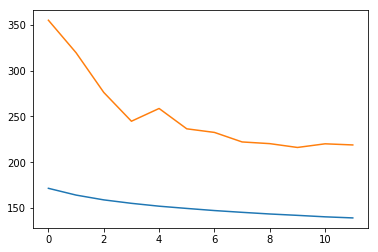

In [15]:
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.show()

In [19]:
save_model(model_save, model_merge)

print(history.history.keys())

Saved model to disk
dict_keys(['val_loss', 'loss'])


In [81]:
model = load_model(model_save)
model_save = '/ssd_scratch/cvit/isha/DGAZE2/DGAZE_weights/weights_proposed_approach'
save_model(model_save, model)

print(history.history.keys())
model.compile(loss='mae', optimizer=opt)

Loaded model from disk
Saved model to disk
dict_keys(['val_loss', 'loss'])


In [ ]:
def gaze_error(model, data):
    scores = model.evaluate([data['left_eye'], data['face_features']], data['gaze_point'][:,:2])
    return scores


In [83]:
model = load_model(model_save)
model.compile(loss='mae', optimizer=opt)

train_error = gaze_error(model, train)
val_error = gaze_error(model, val)
test_error = gaze_error(model, test)
    
print("Train Error ==> ", train_error)
print("Val Error ==> ",  val_error)
print("Test Error ==> " ,test_error)

Loaded model from disk
3761/3761 [==============================] - 0s 89us/step
Train Error ==>  133.3476467606369
Val Error ==>  204.7756923205385
Test Error ==>  186.89798304692954


In [22]:
# for driver in data_split['drivers_test']:

#     data_calibrate = dataset(driver_data, [driver], np.arange(1,113))
#     model_merge = load_model(model_save)
    
#     opt = Adam(lr=0.001, decay=0.1 / 200)
#     model_merge.compile(loss='mae', optimizer=opt)
#     scores = model_merge.evaluate([data_calibrate['left_eye'][2000:], data_calibrate['face_features'][2000:]], data_calibrate['gaze_point'][2000:,:2])
#     print("====> Before Calibration", scores)                   

#     history = model_merge.fit([data_calibrate['left_eye'][:2000], data_calibrate['face_features'][:2000]], data_calibrate['gaze_point'][:2000,:2], \
#                     validation_data= ([data_calibrate['left_eye'][2000:], data_calibrate['face_features'][2000:]],data_calibrate['gaze_point'][2000:,:2]),
#                     epochs = 20, batch_size = 32, verbose=1, shuffle= True)

#     scores = model_merge.evaluate([data_calibrate['left_eye'][2000:], data_calibrate['face_features'][2000:]], data_calibrate['gaze_point'][2000:,:2])

#     print("====> After Calibration", scores) 

In [79]:
te_error = 0; tr_error = 0
for driver in data_split['drivers_val']:
    data_calibrate = dataset(driver_data, [driver], np.arange(1,15))
                         
    te_calibrate = dataset(driver_data, [driver], data_split['sequence_val'])

    print(te_calibrate['gaze_point'].shape)
    opt = Adam(lr=0.0000001)
    
    model_merge = load_model(model_save)
    for layer in model_merge.layers[:1]:
        layer.trainable = False
        
    model_merge.compile(loss = 'mae', optimizer = opt)
    
    error = gaze_error(model_merge, te_calibrate)
    tr_error += error
    print("Test Error ==> " ,error)
              

        
    model_merge.fit([data_calibrate['left_eye'], data_calibrate['face_features']], data_calibrate['gaze_point'][:,:2], \
                validation_data= ([te_calibrate['left_eye'], te_calibrate['face_features']],te_calibrate['gaze_point'][:,:2]),
                epochs = 10, batch_size = 8, callbacks = [earlystopping], verbose=1, shuffle= True)


    error = gaze_error(model_merge, te_calibrate)
    te_error += error
    print("Test Error ==> " ,error)
                         
print("Total test error -->", tr_error/len(data_split['drivers_val']), te_error/len(data_split['drivers_val']))
                         
    

100%|██████████| 1/1 [00:00<00:00, 15.16it/s]


(2480, 6)
Loaded model from disk
2480/2480 [==============================] - 2s 978us/step
Test Error ==>  253.85731683546496
Train on 1316 samples, validate on 2480 samples
Epoch 1/10
1316/1316 [==============================] - 7s 5ms/step - loss: 217.3141 - val_loss: 253.2945
Epoch 2/10
1316/1316 [==============================] - 2s 1ms/step - loss: 215.5906 - val_loss: 252.5813
Epoch 3/10
1316/1316 [==============================] - 2s 1ms/step - loss: 213.5206 - val_loss: 251.8664
Epoch 4/10
1316/1316 [==============================] - 2s 1ms/step - loss: 210.8198 - val_loss: 251.3260
Epoch 5/10
2480/2480 [==============================] - 0s 81us/step
Test Error ==> 

100%|██████████| 1/1 [00:00<00:00, 32.44it/s]

 250.89474332255702



100%|██████████| 1/1 [00:00<00:00, 17.77it/s]

(2299, 6)


Loaded model from disk
2299/2299 [==============================] - 2s 1ms/step
Test Error ==>  151.82987633929557
Train on 1296 samples, validate on 2299 samples
Epoch 1/10
1296/1296 [==============================] - 6s 5ms/step - loss: 199.3381 - val_loss: 151.0309
Epoch 2/10
1296/1296 [==============================] - 2s 1ms/step - loss: 196.3111 - val_loss: 150.3615
Epoch 3/10
1296/1296 [==============================] - 2s 1ms/step - loss: 193.4979 - val_loss: 149.8555
Epoch 4/10
1296/1296 [==============================] - 2s 1ms/step - loss: 189.9718 - val_loss: 149.5299
Epoch 5/10
2299/2299 [==============================] - 0s 80us/step
Test Error ==>  149.28748530935027
Total test error --> 202.84359658738026 200.09111431595363


In [77]:
te_error = 0; tr_error = 0
for driver in data_split['drivers_test']:
    data_calibrate = dataset(driver_data, [driver], np.arange(1,15))
                         
    te_calibrate = dataset(driver_data, [driver], data_split['sequence_test'])

    print(te_calibrate['gaze_point'].shape)
    
#     opt = Adam(lr=0.000000009)
    opt = Adam(lr=0.00000001)
    model_merge = load_model(model_save)
    for layer in model_merge.layers[:1]:
        layer.trainable = False
        
    model_merge.compile(loss = 'mae', optimizer = opt)
    
    error = gaze_error(model_merge, te_calibrate)
    tr_error += error
    print("Test Error ==> " ,error)
              

        
    model_merge.fit([data_calibrate['left_eye'], data_calibrate['face_features']], data_calibrate['gaze_point'][:,:2], \
                validation_data= ([te_calibrate['left_eye'], te_calibrate['face_features']],te_calibrate['gaze_point'][:,:2]),
                epochs = 10, batch_size = 16, verbose=1, shuffle= True)


    error = gaze_error(model_merge, te_calibrate)
    te_error += error
    print("Test Error ==> " ,error)
                         
print("Total test error -->", tr_error/len(data_split['drivers_test']), te_error/len(data_split['drivers_val']))
                         
    

100%|██████████| 1/1 [00:00<00:00, 19.16it/s]


(1743, 6)
Loaded model from disk
1743/1743 [==============================] - 2s 1ms/step
Test Error ==>  189.73342510536355
Train on 1291 samples, validate on 1743 samples
Epoch 1/10
1291/1291 [==============================] - 5s 4ms/step - loss: 201.6692 - val_loss: 189.7588
Epoch 2/10
1291/1291 [==============================] - 1s 574us/step - loss: 201.1549 - val_loss: 189.7831
Epoch 3/10
1291/1291 [==============================] - 1s 577us/step - loss: 202.2824 - val_loss: 189.8053
Epoch 4/10
1291/1291 [==============================] - 1s 574us/step - loss: 200.8743 - val_loss: 189.8328
Epoch 5/10
1291/1291 [==============================] - 1s 577us/step - loss: 201.2706 - val_loss: 189.8586
Epoch 6/10
1291/1291 [==============================] - 1s 576us/step - loss: 201.0266 - val_loss: 189.8846
Epoch 7/10
1291/1291 [==============================] - 1s 577us/step - loss: 198.9562 - val_loss: 189.9084
Epoch 8/10
1291/1291 [==============================] - 1s 574us/step - l

100%|██████████| 1/1 [00:00<00:00, 30.70it/s]

Test Error ==>  189.98639864327916



100%|██████████| 1/1 [00:00<00:00, 15.34it/s]

(2018, 6)


Loaded model from disk
2018/2018 [==============================] - 2s 1ms/step
Test Error ==>  184.44893477622298
Train on 1317 samples, validate on 2018 samples
Epoch 1/10
1317/1317 [==============================] - 6s 4ms/step - loss: 224.0761 - val_loss: 184.4357
Epoch 2/10
1317/1317 [==============================] - 1s 604us/step - loss: 223.1319 - val_loss: 184.4304
Epoch 3/10
1317/1317 [==============================] - 1s 606us/step - loss: 222.3167 - val_loss: 184.4243
Epoch 4/10
1317/1317 [==============================] - 1s 605us/step - loss: 222.5670 - val_loss: 184.4185
Epoch 5/10
1317/1317 [==============================] - 1s 604us/step - loss: 221.2289 - val_loss: 184.4110
Epoch 6/10
1317/1317 [==============================] - 1s 604us/step - loss: 222.2403 - val_loss: 184.4067
Epoch 7/10
1317/1317 [==============================] - 1s 602us/step - loss: 222.0567 - val_loss: 184.4017
Epoch 8/10
1317/1317 [==============================] - 1s 602us/step - loss: 221.